In [135]:
import sys, os
sys.path.append('/Users/benjamin/Desktop/repos/chi-data/backend/aws') 
sys.path.append('/Users/benjamin/Desktop/repos/chi-data/backend') 
from s3 import S3
from dynamo import DynamoConn
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
%matplotlib inline
from config import cook_tracts, chicago_tracts, msa_tracts

In [136]:
import s3fs
s3 = s3fs.S3FileSystem()
dataset = 'JT00'
year = '2002'
ds = pq.ParquetDataset(path_or_paths=[
  'bnroths/chicago-data/lehd_od/year=%s/il_lehd_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/il_lehd_od_aux_%s_%s.parquet' % (year, dataset, year), 
    
  'bnroths/chicago-data/lehd_od/year=%s/in_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/in_od_aux_%s_%s.parquet' % (year, dataset, year), 
    
  'bnroths/chicago-data/lehd_od/year=%s/wi_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/wi_od_aux_%s_%s.parquet' % (year, dataset, year), 

], filesystem=s3, validate_schema=False)

In [137]:
table = ds.read(columns=['w_tract', 'h_tract', 'S000'])
df = table.to_pandas()

In [159]:
#print df.head(n=10)
print df.w_tract.max()

55141011700


In [156]:
# df['h_in_msa'] = df['h_tract'].isin(msa_tracts)
#print type(msa_tracts)
df['h_in_msa'] = df.apply(lambda row: row in msa_tracts)
# df = df[
# df = df[df['w_tract'].isin(msa_tracts)]

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', u'occurred at index w_tract')

In [ ]:
print df.head(n=300)
#'17001010400'.isin(msa_tracts)

In [19]:
diff1 = set(df.h_tract) - set(df.w_tract)
for tract in diff1:
	df = df[df.h_tract != tract]

diff2 = set(df.w_tract) - set(df.h_tract)
for tract in diff2:
	df = df[df.w_tract != tract]

In [20]:
diff1 = set(df.h_tract) - set(df.w_tract)
diff2 = set(df.w_tract) - set(df.h_tract)
print diff1, diff2
print df.head()
print df.shape

set([]) set([])
            w_tract      h_tract  S000
186220  17031010100  17031818500     1
186221  17031010100  17031010600     1
186222  17031010100  17031010600     1
186223  17031010100  17031020100     1
186224  17031010100  17031020500     1
(3706288, 3)


In [29]:
print df.sort_values(by='S000', ascending=False)[df.w_tract=='17031839100'].head()

             w_tract      h_tract  S000
2262780  17031839100  17031060900    61
2267407  17031839100  17031390700    31
2267194  17031839100  17031320100    24
2262775  17031839100  17031060800    21
2267406  17031839100  17031390700    21


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from IPython.kernel.zmq import kernelapp as app
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2262780    61
2267407    31
2267194    24
2262775    21
2267406    21
Name: S000, dtype: int64


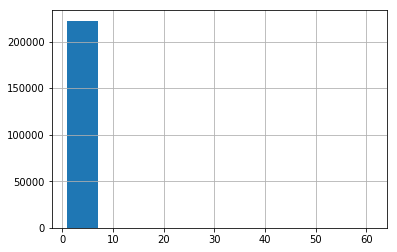

In [87]:

print df.sort_values(by='S000', ascending=False)[df.w_tract=='17031839100']['S000'].head()#hist(bins=100)

df.sort_values(by='S000', ascending=False)[df.w_tract=='17031839100']['S000'].hist()

In [56]:
pivot = pd.pivot_table(df, values='S000', columns=['w_tract'], index=['h_tract'], aggfunc=np.sum, fill_value=0)

Axes(0.125,0.125;0.775x0.755)


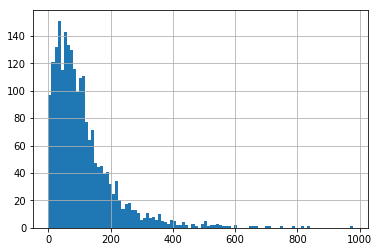

In [85]:
#print pivot[pivot.'17031839100'].head()
print pivot['17031839100'].hist(bins=100)#sort_values(ascending=False)

# df['S000'].sum()#['17001010400']#.head(n=100) #17001010100

In [81]:
pivot.to_csv('/Users/benjamin/Desktop/repos/chi-data/scripts/test.csv')

In [79]:
w_tracts = pivot.sum()
print w_tracts['17031839100']
h_tracts = pivot.transpose().sum()
A = pivot.transpose()/h_tracts
A = A.fillna(0).replace([np.inf, -np.inf], 0)

247951


In [76]:
print A#['17031839100'].sort_values(ascending=False)
#for a in h_tracts:
#    print a

h_tract      17031010100  17031010201  17031010202  17031010300  17031010400  \
w_tract                                                                        
17031010100     0.023069     0.005405     0.004753     0.006017     0.002346   
17031010201     0.002508     0.005019     0.008555     0.001880     0.000939   
17031010202     0.003511     0.008494     0.008555     0.003761     0.000469   
17031010300     0.010030     0.004247     0.001901     0.020308     0.003285   
17031010400     0.005015     0.002703     0.000951     0.010530     0.091976   
17031010501     0.000000     0.000386     0.000000     0.000376     0.000000   
17031010502     0.000000     0.001544     0.003802     0.000000     0.000000   
17031010503     0.000000     0.000386     0.000000     0.000752     0.000000   
17031010600     0.002006     0.008880     0.003802     0.008650     0.002346   
17031010701     0.000000     0.000000     0.000000     0.000000     0.000000   
17031010702     0.000502     0.003089   

In [88]:
w, v = np.linalg.eig(A)

In [89]:
print type(w[0])
print v[0].shape
print w.shape # eigenvalue
print v.shape # eigenvector

<type 'numpy.complex128'>
(2207,)
(2207,)
(2207, 2207)


In [90]:
eigs = []
idx = w.argsort()[::-1]
eigenValues = w[idx]
eigenVectors = v[:,idx]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12216d8d0>]], dtype=object)

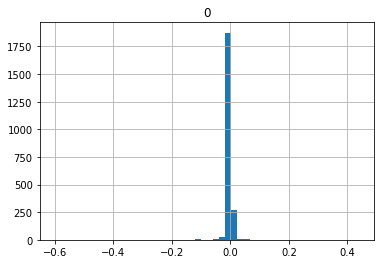

In [134]:
pd.DataFrame(eigenVectors[:,1]).hist(bins=50)

In [ ]:

# print eigenValues
# assert False
# for i in range(eigenValues.shape[0]):
sub_data = []
for i in range(5):
    eigenvalue_i = i+1
    val = round(eigenValues[i], 4)
    vector = eigenVectors[:, i]
    sub_data.append({
        "name": "Eigenvalue %s: %s" % (eigenvalue_i, val),
        "key": str(eigenvalue_i)
    })
    # print i, "value", np.linalg.norm(vector), val
    # print "vector"
    # print vector
    # print type(vector.real)
    transformed = [round(1000*x, 1) for x in vector.real]
    eig = {
        "row": i,
        "value": val,
        "vector": transformed,
        "columns": pivot.columns
    }
    eigs.append(eig)
#     print eigs
    tracts = {}
    for i, column in enumerate(pivot.columns):
        tracts[column] = transformed[i]
        
#     print min(tracts.values())
    


In [ ]:

a = np.array([[0, 1], [-2, -3]])
print a
w, v = np.linalg.eig(a)
print v, w

print w[0], v[:,0]
print w[1], v[:,1]

In [ ]:
from s3 import S3
s3 = S3()